# Musical Instrument Recognition with Spectral Vectors and K-Means

Source: http://www.philharmonia.co.uk/explore/sound_samples/

In [1]:
# Capture Sound Samples

import numpy as np
from scipy import signal
import scipy.io.wavfile as sp
import os

#class that represents an instrument playing a specific note and its segments
class Instrument:
    def __init__(self, name, data, rate, segments):
        self.name = name             # instrument name
        self.data = data             # raw waves for the audio
        self.rate = rate             # sampling rate for the audio
        self.segments = segments     # segmented waves after fourier transform
        
#dictionary of the instruments
instruments = []
        
#iterate through all instrument folders in wav_data
directory = "data/wav_data/"
for folder in os.listdir(directory):
    if "." not in folder:
        #create an instrument object with the appropriate name per folder
        new_instrument = Instrument(folder, [], [], [])
        #iterate through all .wav files in folders
        for file_path in os.listdir(directory + folder):
            if file_path.endswith(".wav"):
                #rate = frames per second, data = the frames
                rate, data = sp.read(directory + folder + "/" + file_path)
                #append the data and rate for the sample
                new_instrument.data.append(data)
                new_instrument.rate.append(rate)
        #add instrument to instruments list
        instruments.append(new_instrument)   
        #print that new instrument was added
        print(new_instrument.name, 'added')
    
print('FINISHED')

banjo added
bass clarinet added
bass drum added
cello added
clash cymbals added
cowbell added
double bass added
flute added
french horn added
guitar added
oboe added
saxophone added
snare drum added
tambourine added
triangle added
trombone added
trumpet added
tuba added
viola added
violin added
FINISHED


## Feature Extraction
- Regularize to mean volume
- Get short time fourier transform
- Convert Segments into Spectral Vectors

In [2]:
# Rescaling and Spectral Vectors

import scipy

#find mean volume of sound samples 
lists_of_tops = [[np.max(sample) for sample in instrument.data] for instrument in instruments]
list_of_tops = [top for list_of_tops in lists_of_tops for top in list_of_tops]
mean_volume = np.mean(list_of_tops)  

#scale the volume for all the audio samples
def scale_volume(data, avg_volume = mean_volume):
    final_scale = avg_volume / (max(-1 * min(data), max(data)))
    return data * final_scale

def stft_custom(x, fs, framesz=0.025, hop=0.01):
    framesamp = int(framesz*fs)
    hopsamp = int(hop*fs)
    w = scipy.hanning(framesamp)
    X = scipy.array([scipy.fft(w*x[i:i+framesamp]) 
                     for i in range(0, len(x)-framesamp, hopsamp)])
    return X

#scale the data and perform stft
for instrument in instruments:
    for i in range(0, len(instrument.data)):
        
        #rescale data
        #instrument.data[i] = scale_volume(instrument.data[i])

        #get the data and rate
        data = instrument.data[i]
        rate = instrument.rate[i]

        #duration = number of frames / frames per second
        duration = len(data) / rate

        #overlap = frames per 10ms
        overlap = rate/1000*10
        overlap = int(overlap)

        #window_size = frames per 25ms
        window_size = rate/1000*25
        window_size = int(window_size)

        #extract frame segments with overlaps
        #f, t, Zxx = signal.stft(data, window = 'hann', nperseg = window_size, noverlap = overlap)
        Zxx = stft_custom(data, rate)
        
        #log of the absolute values of each segment
        Zxx = abs(Zxx)
        Zxx = [[np.log10(d) if d != 0 else 0.0 for d in segment] for segment in Zxx]
        
        #add the stft result to the instrument
        instrument.segments.append(Zxx)
        
        if i == 10: break # TODO remove limit on sample count
        
    print(instrument.name + ' segmented')
    
print('FINISHED')

banjo segmented
bass clarinet segmented
bass drum segmented
cello segmented
clash cymbals segmented
cowbell segmented
double bass segmented
flute segmented
french horn segmented
guitar segmented
oboe segmented
saxophone segmented
snare drum segmented
tambourine segmented
triangle segmented
trombone segmented
trumpet segmented
tuba segmented
viola segmented
violin segmented
FINISHED


## Plotting out sound samples 

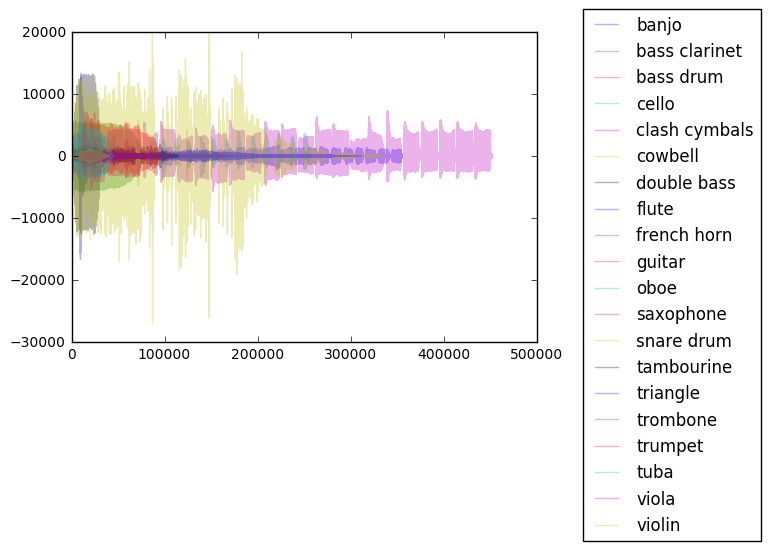

In [3]:
# Plot out all audio samples

import matplotlib.pyplot as plt
   
for instrument in instruments:
    plt.plot(instrument.data[0], label=instrument.name, alpha=0.3)
    
plt.legend(bbox_to_anchor=(1.5, 1.1))
plt.show()

## Multilayer Perceptron

In [4]:
# Prep Data
from sklearn.model_selection import train_test_split

X = []
y = []

for instrument in instruments:
    #print(instrument.name,'instrument.segments:',len(instrument.segments))
    for segments in instrument.segments:
        #print('\t segments length:',len(segments))
        for segment in segments:
            X.append(segment)
            y.append(instrument.name)
            #print('\t\t segment length:',len(segment))
    
X = np.array(X) 
y = np.array(y)

# Test Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y)

print('Data was captured!')

Data was captured!


In [5]:
# sklean Multilayer Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score

net = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)

net.fit(X_train,y_train)
predictions = net.predict(X_test)

print('Accuracy on Train Set:', net.score(X_train,y_train))
print('Accuracy on Test Set:', net.score(X_test,y_test))
print('F1 Score:', f1_score(y_test,predictions,average='micro'))

Accuracy on Train Set: 0.47445175916641236
Accuracy on Test Set: 0.4730578080041852
F1 Score: 0.4730578080041852


In [6]:
# Cross Validate Results
from sklearn.model_selection import cross_val_score

k = 3
scores = cross_val_score(MLPClassifier(solver='lbfgs', alpha=1e-5,
                            hidden_layer_sizes=(5, 2), random_state=1), 
                         X, y, cv=k)
print(str(k) + '-Fold Score: ' + str(np.mean(scores)) + " (" + str(scores) + ")")

3-Fold Score: 0.37299426466991753 ([0.33737007 0.36158525 0.42002748])


## Confusion Matrix for Neural Network

Confusion matrix, without normalization
[[ 341    9    5    0    0    0    0    0    0  515    0  172    0    1
     0    0    0    1    0    0]
 [  13  926  122    0    0    0    0    0    0   22    0  117    0    0
     0    0    0   22    0    0]
 [  21  374  557    0    0    0    0    0    0   34    0  170    0    3
     0    0    0  100    0    0]
 [  81   16  126    0    0    0    0    0    0  104    0   83    0    2
     0    0    0   37    0    0]
 [  18    0    0    0    0    0    0    0    0   19    0  275    0    3
     0    0    0    0    0    0]
 [  12    0    0    0    0    0    0    0    0    2    0  121    0    0
     0    0    0    0    0    0]
 [   4  162   29    0    0    0    0    0    0    2    0  192    0    0
     0    0    0    2    0    0]
 [ 111    0    0    0    0    0    0    0    0   35    0  373    0    0
     0    0    0    0    0    0]
 [   7    0    0    0    0    0    0    0    0  341    0    1    0   64
     0    0    0    0    0    0]
 [ 111    2    

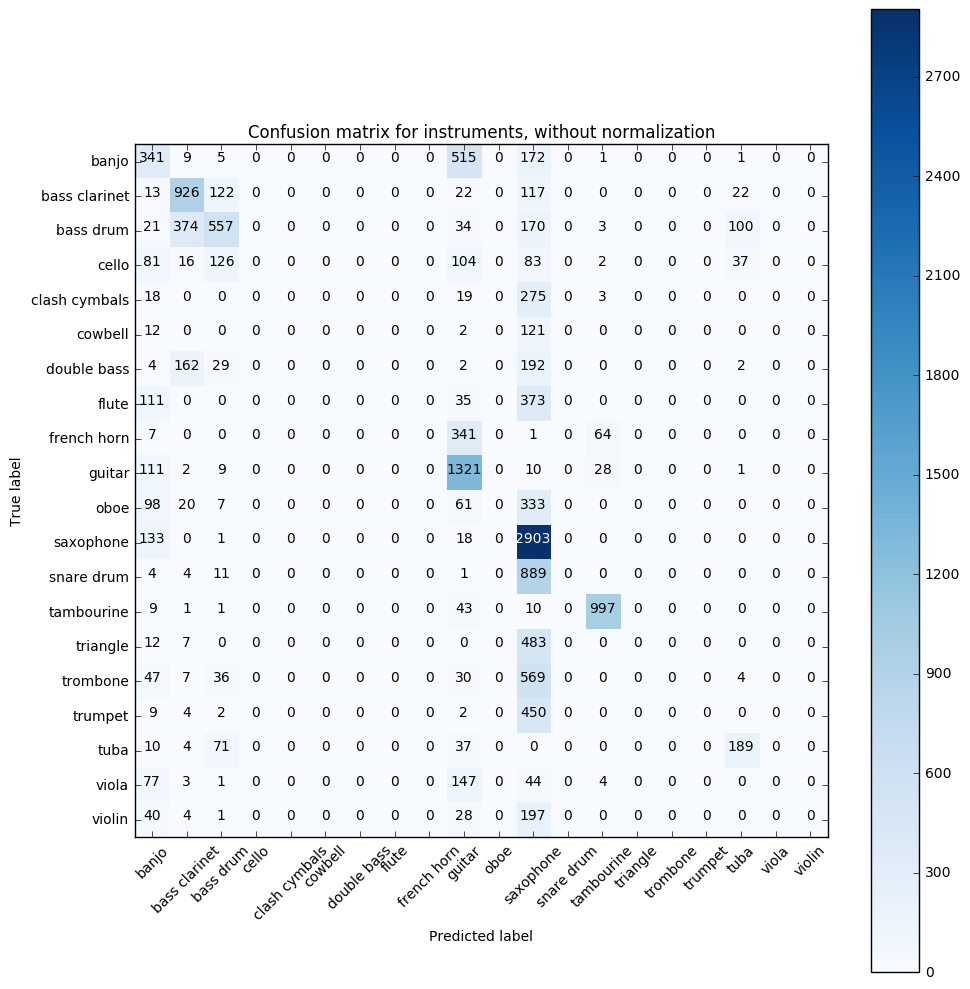

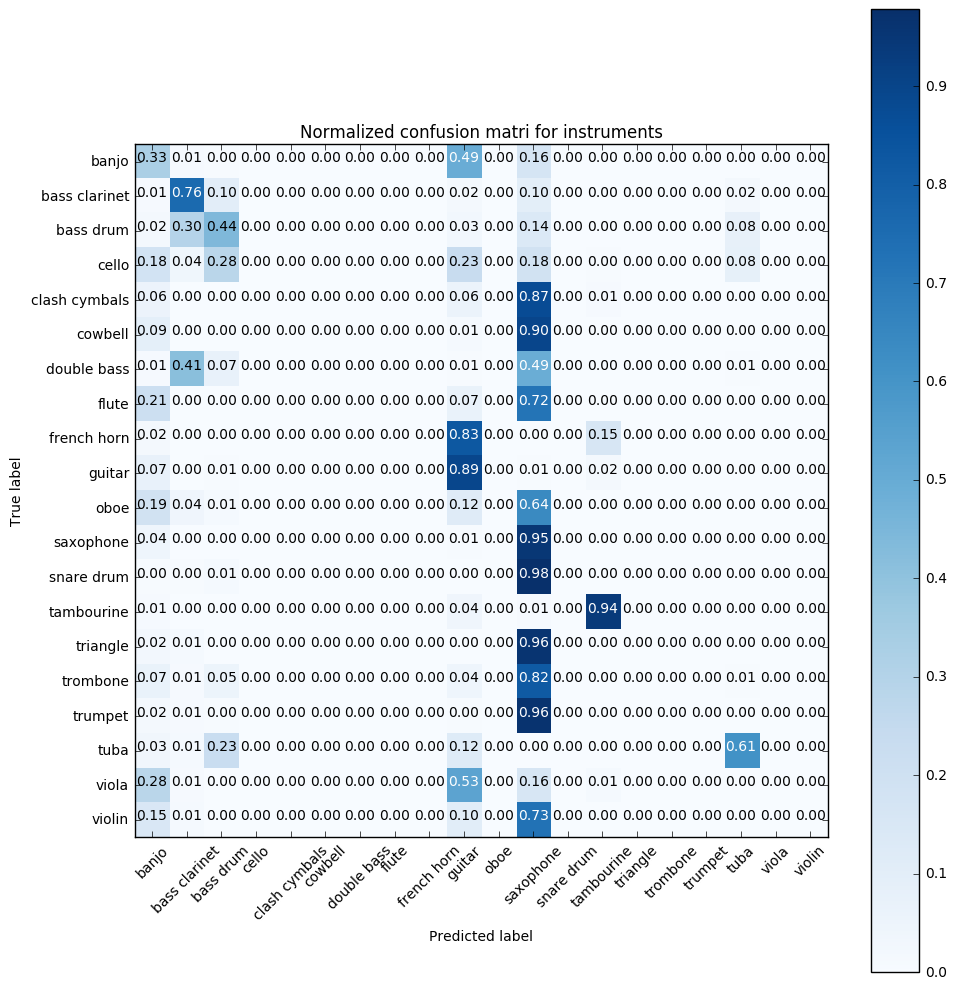

In [7]:
import itertools

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

confusion_matrix = confusion_matrix(y_test, predictions)
np.set_printoptions(precision=2)

instrument_names = [instrument.name for instrument in instruments]

plt.figure(figsize=(10,10))
plot_confusion_matrix(confusion_matrix, classes=instrument_names,
                      title = 'Confusion matrix for instruments, without normalization')

plt.figure(figsize=(10,10))
plot_confusion_matrix(confusion_matrix, classes=instrument_names, normalize=True,
                      title = 'Normalized confusion matri for instruments')
        
plt.show()

## Guess Instrument with Neural Network

In [50]:
def guess_instrument_nn(wav_file_path):
    rate, data = sp.read(wav_file_path)
    
    Zxx = stft_custom(data, rate)
    Zxx = abs(Zxx)
    segments = [[np.log10(d) if d != 0 else 0.0 for d in segment] for segment in Zxx]
    
    guess_per_seg = list(net.predict(segments))
    
    final_guess = max(set(guess_per_seg), key=guess_per_seg.count)
    print("Final Guess: " + final_guess+'\n')
    print(guess_per_seg)

In [63]:
snare_drum = "data/wav_data/snare_drum/407.wav"
snare_drum2 = "data/wav_data/snare_drum/Mono Little Perc-408.wav"
saxophone = "data/wav_data/saxophone/Audio 5_04.wav"
trombone = "data/wav_data/trombone/Trombone Mono-135.L.wav"
tuba = "data/wav_data/tuba/Tuba Mono-66.wav"
violin = "data/wav_data/violin/0360.wav"
french_horn = "data/wav_data/french_horn/2 1.wav"
cello = "data/wav_data/cello/118.wav"
guitar = "data/wav_data/guitar/028.wav"

guess_instrument_nn(guitar)

Final Guess: guitar

['banjo', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'banjo', 'guitar', 'banjo', 'banjo', 'guitar', 'banjo', 'banjo', 'saxophone', 'saxophone', 'saxophone', 'saxophone', 'saxophone', 'saxophone', 'saxophone', 'saxophone', 'saxophone', 'saxophone', 'saxophone', 'saxophone', 'saxophone', 'saxophone', 'saxophone', 'saxophone', 'banjo', 'saxophone', 'saxophone', 'banjo', 'banjo', 'banjo', 'saxophone', 'saxophone', 'saxophone', 'saxophone', 'banjo', 'banjo', 'saxophone', 'banjo', 'banjo', 'banjo', 'guitar', 'guitar', 'banjo', 'saxophone', 'banjo', 'banjo', 'banjo', 'banjo', 'banjo', 'banjo', 'banjo', 'banjo', 'banjo', 'banjo', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'banjo', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'guitar', 'banjo', 'guitar', 'guitar', 'banjo', 'guitar', 'guit

## Create Codebooks/Clusters for each instrument
- Clusters are generated with K-Means

In [8]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

# Put all spectral vectors of all samples for each instrument into separate arrays
clusters = {}
for instrument in instruments:
    spectral_vectors = []
    for Zxx in instrument.segments:
        for spectral_vector in Zxx:
            spectral_vectors.append(spectral_vector)
    clusters[instrument.name] = spectral_vectors
print("Captured Spectral Vectors")   
    
for instrument_name, vectors in clusters.items():
    clusters[instrument_name] = KMeans(n_clusters = 512, random_state = 1).fit(vectors)
    print(instrument,"codebook created")
    
print("FINISHED")

In [65]:
# Now use your test data---for each speaker randomly assign 10% of data as the test---
# and compare the test spectral vectors of the input speaker to m codebooks of each
# speaker.
for instrument in instruments:
    closest_instruments = {}
    X = []
    y = []
    for Zxx in instrument.segments:
        for spectral_vector in Zxx:
            X.append(spectral_vector)
            y.append(instrument.name)
    X = np.array(X) 
    y = np.array(y)
    # Test Train Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
    # Find the speaker whose spectral vector distant of its codebooks to the input spectral
    # vectors is minimum. And select that speaker as the identified speaker from your
    # machine.
    for instrument_name, cluster in clusters.items():
        #indices of closest cluster per segment in X
        cluster_indices = cluster.predict(X_test)
        #calculate distances from segment point 
        closest_cluster_center_coordinates=[cluster.cluster_centers_[i] for i in cluster_indices]
        for i in range(0, len(closest_cluster_center_coordinates)):
            a = X_test[i]
            b = closest_cluster_center_coordinates[i]
            distance = np.linalg.norm(b-a)
            if i not in closest_instruments.keys():
                closest_instruments[i] = (instrument_name, distance)
            if distance < closest_instruments[i][1]:
                closest_instruments[i] = (instrument_name, distance)
    guess_per_seg = ([closest_instrument[0] for closest_instrument in closest_instruments.values()])
    final_guess = max(set(guess_per_seg), key=guess_per_seg.count)
    print("Final Guess: " + final_guess + ", Actual Instrument: " + instrument.name)

Final Guess: banjo, Actual Instrument: banjo
Final Guess: bass clarinet, Actual Instrument: bass clarinet
Final Guess: bass drum, Actual Instrument: bass drum
Final Guess: cello, Actual Instrument: cello
Final Guess: clash cymbals, Actual Instrument: clash cymbals
Final Guess: cowbell, Actual Instrument: cowbell
Final Guess: double bass, Actual Instrument: double bass
Final Guess: flute, Actual Instrument: flute
Final Guess: french horn, Actual Instrument: french horn
Final Guess: guitar, Actual Instrument: guitar
Final Guess: oboe, Actual Instrument: oboe
Final Guess: saxophone, Actual Instrument: saxophone
Final Guess: snare drum, Actual Instrument: snare drum
Final Guess: tambourine, Actual Instrument: tambourine
Final Guess: triangle, Actual Instrument: triangle
Final Guess: trombone, Actual Instrument: trombone
Final Guess: trumpet, Actual Instrument: trumpet
Final Guess: tuba, Actual Instrument: tuba
Final Guess: viola, Actual Instrument: viola
Final Guess: violin, Actual Instrum

## Guess Instruments with 512-Means Codebooks

In [23]:
def guess_instrument_kmeans(wav_file_path):
    rate, data = sp.read(wav_file_path)
    
    overlap = rate/1000*10
    overlap = int(overlap)
    
    window_size = rate/1000*25
    window_size = int(window_size)
    
    Zxx = stft_custom(data, rate)
    Zxx = abs(Zxx)
    segments = [[np.log10(d) if d != 0 else 0.0 for d in segment] for segment in Zxx]
    
    closest_instruments = {}
    for instrument_name, cluster in clusters.items():
        #indices of closest cluster per segment in segments
        cluster_indices = cluster.predict(segments)
        #calculate distances from segment point 
        closest_cluster_center_coordinates=[cluster.cluster_centers_[i] for i in cluster_indices]
        for i in range(0, len(closest_cluster_center_coordinates)):
            a = segments[i]
            b = closest_cluster_center_coordinates[i]
            distance = np.linalg.norm(b-a)
            if i not in closest_instruments.keys():
                closest_instruments[i] = (instrument_name, distance)
            if distance < closest_instruments[i][1]:
                closest_instruments[i] = (instrument_name, distance)
    guess_per_seg = ([closest_instrument[0] for closest_instrument in closest_instruments.values()])
    #print(guess_per_seg)
    final_guess = max(set(guess_per_seg), key=guess_per_seg.count)
    print("Final Guess: " + final_guess)

In [64]:
snare_drum = "data/wav_data/snare_drum/407.wav"
snare_drum2 = "data/wav_data/snare_drum/Mono Little Perc-408.wav"
saxophone = "data/wav_data/saxophone/Audio 5_04.wav"
trombone = "data/wav_data/trombone/Trombone Mono-135.L.wav"
tuba = "data/wav_data/tuba/Tuba Mono-66.wav"
violin = "data/wav_data/violin/0360.wav"
french_horn = "data/wav_data/french_horn/2 1.wav"
cello = "data/wav_data/cello/118.wav"
guitar = "data/wav_data/guitar/028.wav"

guess_instrument_kmeans(guitar)

Final Guess: guitar
